<a href="https://colab.research.google.com/github/Amrit1Gurung/Quara-Sincerity/blob/main/quara_sincerity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np  
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re           
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences  
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# loading dataset
quara = pd.read_csv('/content/drive/My Drive/programs/Datasets/quora/quora.csv')
print('shape : ', quara.shape)
quara.head()


shape :  (100000, 6)


,qid,question_text,target,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,2cad3a505ddb8aa72b53,Why are most indian parents against even likin...,1,NaN,NaN,NaN
1,e72c34e4fdd593ca8899,"Is it OK that I have a 7"" penis and only 12 ye...",1,NaN,NaN,NaN
2,60e111fdcc9caa3a50ea,Why do guys past 40 who party like they are st...,1,NaN,NaN,NaN
3,3776e33418a90b6f46aa,"Those who say that the Muslim is a traitor, is...",1,NaN,NaN,NaN
4,2f3fac52fade02a70244,What is a proper way to cook a dog?,1,NaN,NaN,NaN


In [ ]:
quara = quara[['question_text','target']]
quara = quara[quara.target.isin(['0','1'])].sample(frac=1).reset_index()  # select class lebel 0 and1 and samplubg dataset
quara = quara.drop('index',axis=1)
quara = quara.drop_duplicates(subset='question_text')
duara = quara.dropna()
quara['target'] = quara['target'].astype('int32')
print('Now the size of the data is : ',quara.shape)

Now the size of the data is :  (99931, 2)


In [ ]:
quara.head()

,question_text,target
0,Why do you not think female circumcision shoul...,1
1,What is the cost of making the glass of a beer...,0
2,Does Jews control Trump’s decisions?,1
3,"Why don't Muslims in India eat rats, dogs, and...",1
4,Why do girls feel so offended when guys look a...,1


In [ ]:
stop_words = set(stopwords.words('english'))
# function to preprocess and remove stopwords
def remove_stopwords(text):
  no_stops = []
  sent = text.lower()
  sent = re.sub(r"[^a-zA-Z]"," ",sent)
  #sent = str(text)
  for w in sent.split():
    if not w in stop_words:
      no_stops.append(w)
  return (" ".join(no_stops))

In [ ]:
quara['clean_question'] = quara['question_text'].apply(lambda x: remove_stopwords(x))

In [ ]:
#loading the glove model
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    word_embeddings = {}
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs
    print ("Done."),len(word_embeddings),(" words loaded!")
    return word_embeddings

In [ ]:
# save the glove model
word_embedding=loadGloveModel("/content/drive/MyDrive/programs/Datasets/Medical Transcriptions/glove.6B.100d.txt")

Loading Glove Model
Done.


In [ ]:
# set independent and target column/feature vector
X = quara['clean_question'].values
Y = quara['target'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)
train_seq = tokenizer.texts_to_sequences(x_train)
test_seq = tokenizer.texts_to_sequences(x_test)
train_pad = pad_sequences(train_seq)
test_pad = pad_sequences(test_seq, maxlen=train_pad.shape[1])
word_index = tokenizer.word_index

print('The number of unique tokens are {}'.format(len(word_index)))
print("Now train and test tensor shape is : ", train_pad.shape,test_pad.shape)
print('target train and test tesor shape is: ', y_train.shape,y_test.shape)


The number of unique tokens are 42566
Now train and test tensor shape is :  (79944, 83) (19987, 83)
target train and test tesor shape is:  (79944,) (19987,)


In [ ]:
vocab_size = len(word_index)+1
sequence_len = train_pad.shape[1]
embedded_dim = 100
# creating embedding matrix
embedding_matrix = np.zeros((vocab_size,embedded_dim))
for word, i in word_index.items():
  embedding_vector = word_embedding.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(42567, 100)

In [ ]:
# Build and train model
def train_model():
  model = Sequential()
  model.add(Embedding(vocab_size, embedded_dim, weights=[embedding_matrix], input_length=sequence_len))
  model.add(LSTM(100))
  model.add(Dropout(0.2))
  model.add(Dense(24, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1 ,activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
model = train_model()
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 83, 100)           4256700   
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 24)                2424      
_________________________________________________________________
dropout_8 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 25        
Total params: 4,339,549
Trainable params: 4,339,549
Non-trainable params: 0
____________________________________________

In [ ]:
history = model.fit(train_pad, y_train, batch_size=150, epochs=5, validation_data=(test_pad, y_test))

Epoch 1/5
533/533 [==============================] - 151s 281ms/step - loss: 0.4034 - accuracy: 0.8270 - val_loss: 0.3019 - val_accuracy: 0.8809
Epoch 2/5
533/533 [==============================] - 152s 285ms/step - loss: 0.2893 - accuracy: 0.8881 - val_loss: 0.2950 - val_accuracy: 0.8835
Epoch 3/5
533/533 [==============================] - 152s 285ms/step - loss: 0.2666 - accuracy: 0.8970 - val_loss: 0.2954 - val_accuracy: 0.8836
Epoch 4/5
533/533 [==============================] - 152s 285ms/step - loss: 0.2511 - accuracy: 0.9043 - val_loss: 0.3003 - val_accuracy: 0.8816
Epoch 5/5
533/533 [==============================] - 151s 284ms/step - loss: 0.2389 - accuracy: 0.9085 - val_loss: 0.3081 - val_accuracy: 0.8815


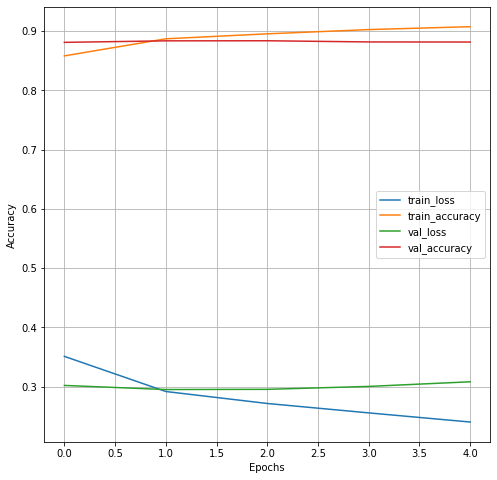

In [ ]:
#save model
model.save('/content/drive/MyDrive/programs/Datasets/quora/lstm_model.h5')

history_df = pd.DataFrame(model.history.history).rename(columns={"loss":"train_loss", "accuracy":"train_accuracy"})
history_df.plot(figsize=(8,8))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
score = model.evaluate(test_pad, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

625/625 [==============================] - 10s 16ms/step - loss: 0.3081 - accuracy: 0.8815
Test Score: 0.3080868721008301
Test Accuracy: 0.8814729452133179
